# Classification of tumors into 2 categories (benign or malignant) based on features of tumor cell nuclei

## The classification problem
A tumor can be malignant (cancerous) or benign (non-cancerous). This classification is made by a pathologist who examines the tumor cells obtained from a biopsy under a microscope. One method employed by pathologists is to examine the shape of a cell nuclei and make a judgement based on it.    
   
The problem that is encountered in this regard, is that the shape is defined by many parameters such as the area of a nuclei, it’s perimeter and numerous other parameters. Making a judgement on which of these parameters are more important relative to other parameters requires a quantitative analysis of the differences in these parameters between the malignant and benign cases.  
   
## Data
The data for this analysis is a csv file containing 30 features of a cell nuclei of a tumor cell. This data can be acquired from the following data base link:   
https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/data

## Approach Summary  
The approach for this problem can be divided into 4 parts:  
  
1- We need to explore the data and clean it.  
2- We need to perform visual exploratory data analysis to check which features differ between the two classes (benign and malignant).  
3- We need to perform some king of statistical test to check which of the differences are statistically significant.  
   
The above mentioned steps will help us gain an intuition about the data and make a qualitative model for the differences between the two classes.   
   
The last part of the approach will be building a predictive model for classification of tumor nuclie. This will include 4 steps.   
   
1- Getting data ready for scikit learn libraries.   
2- Extracting features and reducing the dimensionality of the data. Both of these goals will be accomplished using Pricipal Component Analysis (PCA).   
3- Using the transformed data to build a k-nearest neighbourhood model (KNN).   
4- Using the transformed data to build a logistic regression model (logreg).   


## Importing required libraries  
  
Firstly, we need to import the libraries which we will be using in this analysis.

In [1]:
 # Making interactive plots within the notebook
%matplotlib notebook
# Libraries for importing and manipulating data
import pandas as pd  
import numpy as np 
# Librares for plotting and statistical analysis
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('ggplot') # Setting a plot style to make them asthetically appealing 
import scipy.stats as st 
# Libraries for building predictive models 
from sklearn import decomposition # Used for PCA
from sklearn.neighbors import KNeighborsClassifier # Used for KNN
from sklearn.linear_model import LogisticRegression # Used for logreg
from sklearn.model_selection import GridSearchCV, train_test_split # Used for splitting data and searching for optimized parameters
from sklearn.metrics import classification_report # Used for testing the models

## Importing and cleaning data  
  
Firstly, we need to to import and clean data. In this regard the following steps are required:  

1- Make sure that no samples are duplicated (the patient id column should have no duplicate values).   
2- Column 31 (with all NaN values) is removed.   
3- Worst recorded values are removed. These values are not important for the analysis.   
4- The data is normalized. This is important as features have different scales.   

In [2]:
# Reading data into a dataframe df, with patient id as the index column
df = pd.read_csv('Cancer.csv', index_col = 'id')
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Insights from the data frame
The data frame has 32 columns. One of these is 'diagnosis' which is our target variable. Another is 'Unamed 32' column which contains only NaN values. Therefore, the features of the data are 30. The index column of the data frame contains the patient id. We will use this to make sure that no sample is repeated (every row must have a unique patient id). The data also has columns with names ending with 'worst'. These are the worst estimates of the parameters and we do not need them. Therefore, we need to remove these columns.

In [3]:
# Making sure that no patient data is duplicated
assert df.index.value_counts().max() == 1

In [4]:
# Dropping column which has all null values
df.drop('Unnamed: 32', axis=1, inplace = True)

In [5]:
# Choosing columns with worst at the end of their names
todrop = []
for k in df.columns:
    if '_worst' in k:
        todrop.append(k)
# Dropping these columns
df.drop(todrop,axis=1,inplace=True)

## Resetting index and normalizing data
Now that we have made sure that no samples are duplicated and have removed column named 'Unnamed: 32' and all the columns with names ending with 'worst', we need to set the index of the data frame to our target variable 'diagnosis'. Once this is done, all the columns will contain predictor variables which we can now normalize. We will end up making a new data frame called df_new.

In [6]:
# Creating a new data frame with normalized values and the index set to diagnosis
df.set_index('diagnosis',inplace=True,drop=True) # Setting index to diagnosis (required for normalization)
X = df.values
X_mean = X.mean(axis = 0)
X_std = X.std(axis = 0)
X_norm = (X-X_mean)/X_std
df_new = pd.DataFrame(data = X_norm,index = df.index, columns = df.columns)
df_new.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se
diagnosis,,,,,,,,,,,,,,,,,,,,
M,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,2.489734,-0.565265,2.833031,2.487578,-0.214002,1.316862,0.724026,0.660820,1.148757,0.907083
M,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,0.499255,-0.876244,0.263327,0.742402,-0.605351,-0.692926,-0.440780,0.260162,-0.805450,-0.099444
M,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,1.228676,-0.780083,0.850928,1.181336,-0.297005,0.814974,0.213076,1.424827,0.237036,0.293559
M,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,0.326373,-0.110409,0.286593,-0.288378,0.689702,2.744280,0.819518,1.115007,4.732680,2.047511
M,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,1.270543,-0.790244,1.273189,1.190357,1.483067,-0.048520,0.828471,1.144205,-0.361092,0.499328


## Data ready for visualization and performing statistical analysis  
  
The head of df_new shows that columns now only contain predictive variables and the data has been normalized. Now, we have the data ready for visualization and statistical analysis. 

## Firstly, we need to check for correlation between different parameters.  
The data has columns which are correlated. We can predict this even with out performing a correlation check as area and parimeter will be correlated with the radius. Therefore, it is important that we check for correlation between different variables. We will use a custom function 'plot_corr' for plotting correlation between different variables.

In [7]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr,cmap = 'RdBu',vmin = -1, vmax = 1)
    ticks = np.arange(0,)
    plt.xticks(np.arange(0,len(corr.columns),1), corr.columns, rotation = 90);
    plt.yticks(np.arange(0,len(corr.columns),1), corr.columns);
    plt.colorbar(cax)
    plt.tight_layout()

<IPython.core.display.Javascript object>


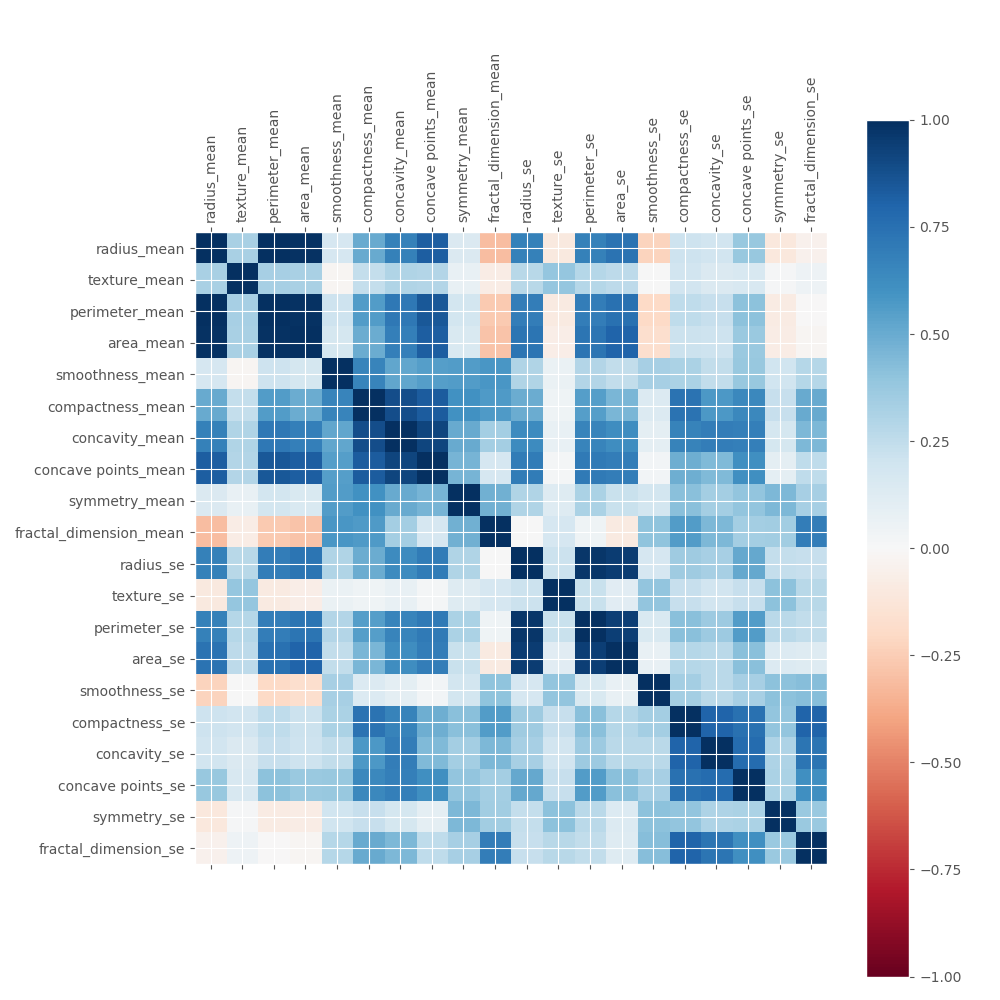

In [8]:
# Visualizing correlation between between different features
plot_corr(df_new);

## Insights from figure 1
As we expected, there is a high correlation between radius, area and parameter. Moreover, we also see a high correlation between between compactness, concavity and number of concave points. The take home message from this figure is that we will need to perfom PCA before building our predictive models

## Visualizing differences between different classes
Now we will melt the data frame. This will make plotting with seaborn easier. Next we will plot box and strip plots to see how the variables differ between malignant and benign cases.

In [9]:
# Melting the data frame to create Parameters and values for each class (malignant and benign)
df_new.reset_index(inplace=True)
df_melt = pd.melt(df_new,id_vars = 'diagnosis', 
                  var_name = 'Parameters', 
                  value_name = 'Values')

<IPython.core.display.Javascript object>


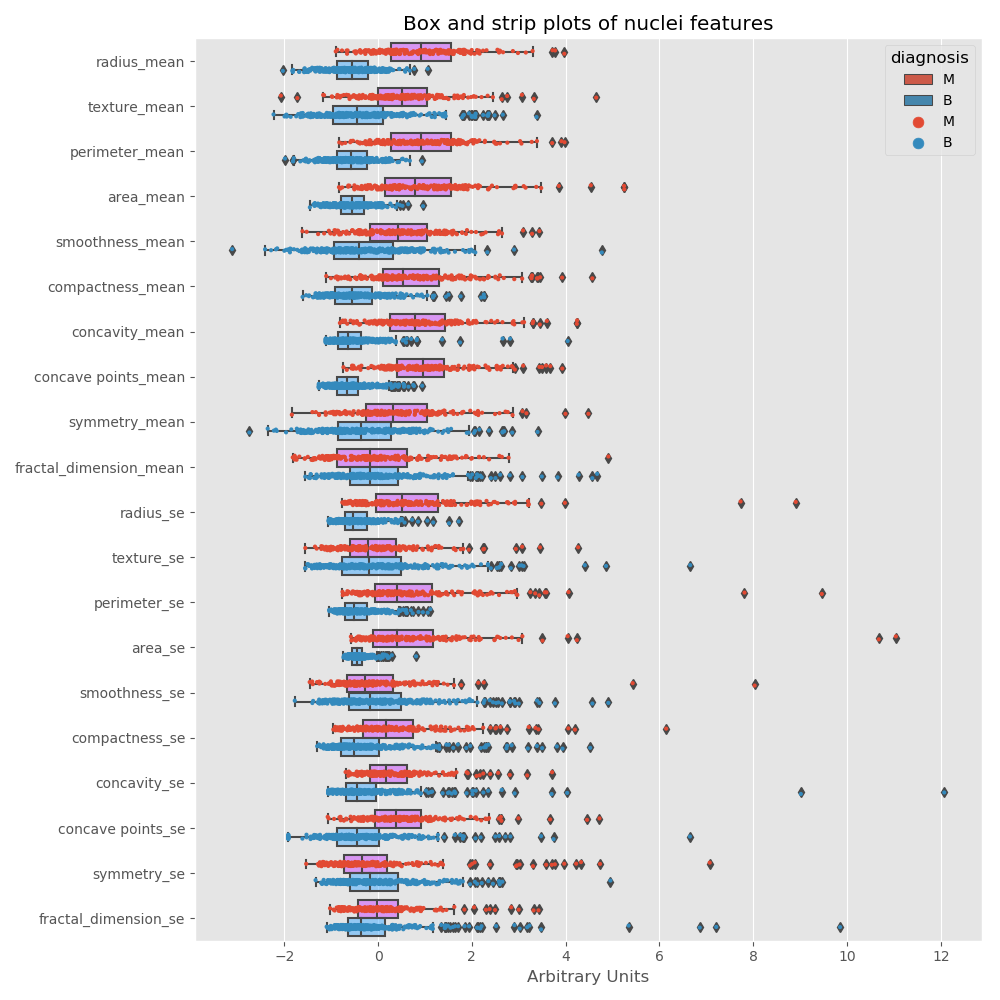

In [10]:
# Making fig and axs objects 
fig, axs = plt.subplots(1,1,figsize = (10,10));
# Setting fig title
plt.title('Box and strip plots of nuclei features', y = 1.0);
# Creating boxplot
sns.boxplot(x='Values',
            y='Parameters',
            hue='diagnosis',
            data=df_melt,
            dodge = True,
            ax=axs)
# Setting transparancy of boxplot to 0.3  
for patch in axs.artists:
    c1, c2, c2, c3 = patch.get_facecolor()
    patch.set_facecolor((c1, c2, c3, .5))
        
# Creating stripplot
sns.stripplot(x='Values',
              y='Parameters',
              hue = 'diagnosis',
              data=df_melt,
              size=3,
              dodge = True,
              jitter = True,
              ax = axs);        
# Removing xlabel and ylabel and setting alphabetical title
axs.set_ylabel('');
axs.set_xlabel('Arbitrary Units');
plt.tight_layout()

## Insights from figure 2
This figure shows that almost all the variables differ between the two classes. This is a good start, but we do not have a quantification of these differences. To quantify the differences, so that we can see which variables show the greatest changes between the two classes will will now calculate percentage changes and plot them.

In [11]:
# Creating a dict to store percentage increases in parameters of malignant compared to benign nuclei
Perc_increase = {}
# Looping over all columns(except diagnosis column) in df and calculating increase in values in malignant as percentage
for k in df.iloc[:,1:]:
    Perc_increase[k] = ((df[df.index == 'M'][k].median() - df[df.index == 'B'][k].median())
     /(df[df.index == 'B'].loc[:,k].median()))*100 

<IPython.core.display.Javascript object>


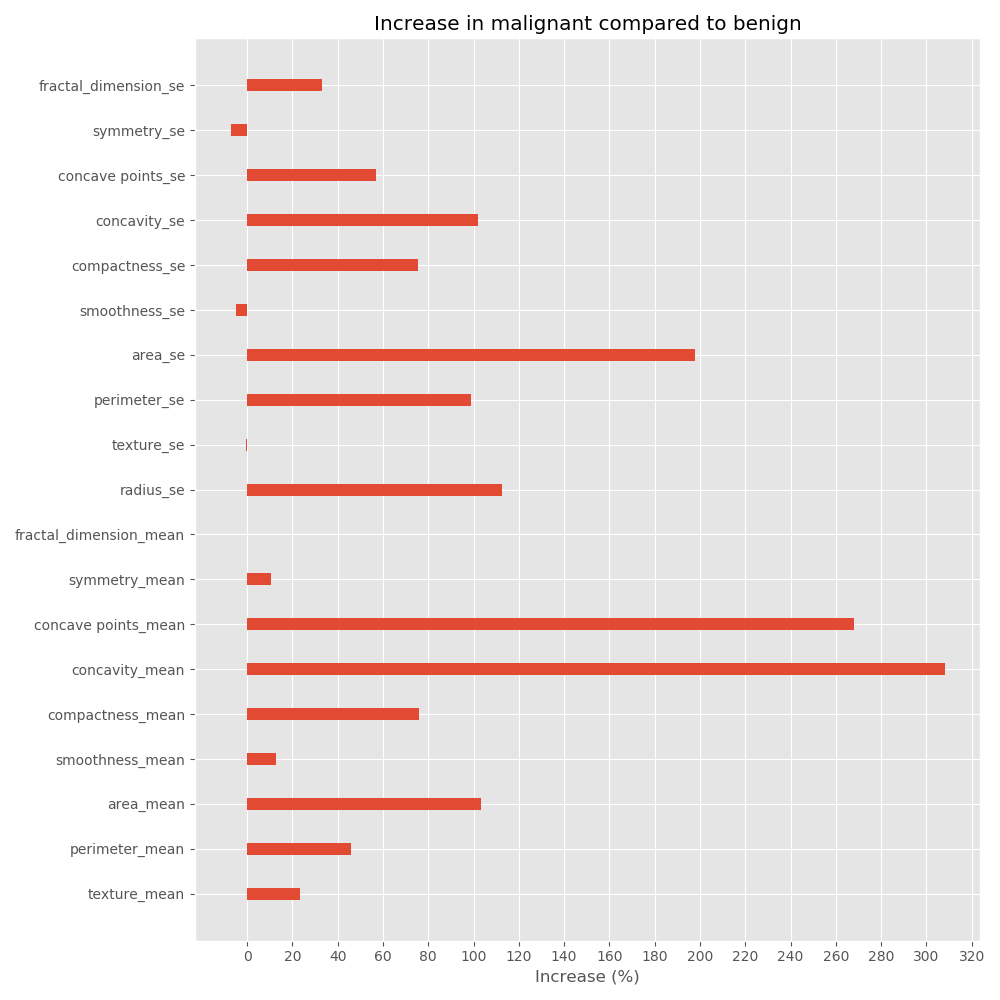

In [12]:
# Creating figure object
fig= plt.figure(figsize = (10,10))
# Plotting percentage increase as horizontal bar plot
plt.barh(list(range(2, len(Perc_increase)*3 + 1, 3)),
         width = list(Perc_increase.values()),
         align='center');
# Placing y ticks with labels
plt.yticks(list(range(2, len(Perc_increase)*3 + 1, 3)), list(Perc_increase.keys()));
# Placing x ticks
plt.xticks(list(range(0, 340, 20)));
# Label x axes 
plt.xlabel('Increase (%)');
# Setting figure title
plt.title('Increase in malignant compared to benign');
plt.tight_layout()

## Insights from figure 3
This figure provides us with more information about the changes in variables between the two classes. We can see that the largest changes are observed in the concavity and the number of concave points. We can also see that the area of malignant nuclei also increases compared to benign nuclei. We already have enough information to build a visual model for the two classes.

## Checking for significant changes
We have already seen that there are differences between the two classes. But, we still do not know which of these changes are statistically significant. To check for this we will first perform a normalcy test and based on the results use a statistical test to check for significant changes. An important point that we need to keep in mind is that we have normalized the data. We needed to do this for easier visualization and building predictive models (which we will do later), but for performing statistical analysis we need non-normalized data. To achieve this all we need to do is to use dataframe df, with it's index reset instead of df_new.

In [13]:
# Resetting the index of df
df.reset_index(inplace=True)
# Creating empty list for storing statistic value of normalcy test
norm_stats = [];
# Creating empty list for storing p value of normalcy test
norm_p = [];
# Looping over all columns(except diagnosis column) in df and checking if they follow a 
# normal distribution
for k in df.iloc[:,1:]:
    # applying normalcy test
    stat_val, p_val = st.normaltest(df[k])
    # appending statistic value to norm_stats 
    norm_stats.append(stat_val)
    # appending p value to norm_p
    norm_p.append(p_val)
# Checking if any distribution is normal
assert (np.array(norm_p) > 0.05).sum() == 0
# Creating a dict to contain p values and U statistic value for mann-whitney test
mw_test = {}
# Looping over all columns(except diagnosis column) in df and checking if benign is different than
# malignant
for k in df.iloc[:,1:]:
    # Applying mann-whitney test
    statmw_val, pmw_val = st.mannwhitneyu(x = df[df['diagnosis'] == 'M'][k],
                                          y = df[df['diagnosis'] == 'B'][k],
                                          alternative = 'greater')
    # Appending statistic and p value to mw_test 
    mw_test[k] = [statmw_val,pmw_val]
# Creating a data frame for mw_test
stats_df = pd.DataFrame(data=mw_test)
# Setting the index of stats_df to names
stats_df.index = ['U_statistic', 'P_value']
# Printing the p-values and mann-whitney statistic value
stats_df.transpose()

,U_statistic,P_value
radius_mean,70955.0,1.346471e-68
texture_mean,58717.5,1.714313e-28
perimeter_mean,71665.0,1.776935e-71
area_mean,71015.5,7.698902e-69
smoothness_mean,54647.0,3.896503e-19
compactness_mean,65374.5,4.475996e-48
concavity_mean,70978.5,1.082274e-68
concave points_mean,72992.5,5.031619e-77
symmetry_mean,52870.0,1.134025e-15
fractal_dimension_mean,36671.5,7.315811e-01


## Insights from statistical analysis
The results from mann-whitney u test show that all the changes between different parameter are statistically significant.

# Predictive models
Now, we build two predictive models: KNN model and logreg model

## Getting data ready for model building
Before building our models we need to get our data ready. This involves the following three steps:  
  
1- Converting our target variable (diagnosis) to binary.

2- Converting the target and predictive variables into numpy arrays.
  
3- Splitting the data into training and testing sets. This is important as we want to test our models on unseen data.
  
4- Normalizing the split datasets.

In [14]:
# Converting dignosis to binary
df.set_index('diagnosis',inplace=True,drop=True) # Setting index to diagnosis (we had reset index during statistical analysis)
for k in df.index:
    if k == 'M':
        df.loc[k,'Diagnosis'] = 1
    else:
        df.loc[k,'Diagnosis'] = 0
# Setting the new binary index
df.set_index('Diagnosis',inplace=True,drop=True)

In [15]:
# Creating features array and target array 
X = df.values
y = np.array(df.index.astype(int))

In [16]:
# Splitting the data into test and training sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state=42)

In [17]:
# Normalizing data
X_train = (X_train - X_train.mean(axis = 0))/X_train.std(axis = 0)
X_test = (X_test - X_test.mean(axis = 0))/X_test.std(axis = 0)

## Performing PCA
Now, we will perform pca on the data. We do this for feature extraction and dimensionality reduction. Moreover, as we already know that there are correlations between predictive variables, pca becomes even more important.

In [18]:
pca = decomposition.PCA()

In [19]:
# Using pca fit method on the training data
pca.fit(X_train);

<IPython.core.display.Javascript object>


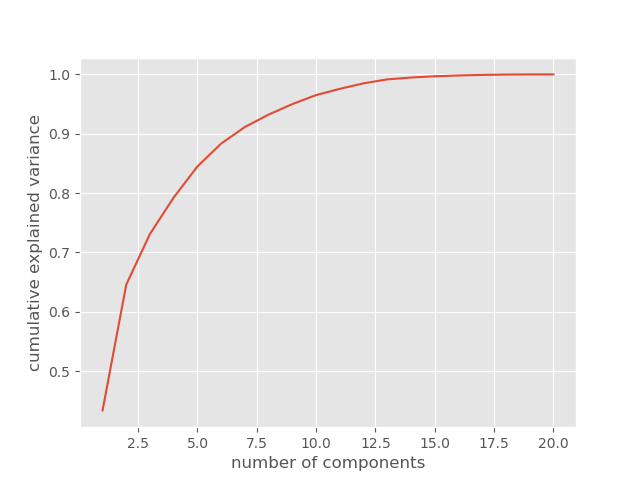

In [20]:
# Plotting cumulative explained variance vs. number of components
# Creating figure object
fig= plt.figure()
plt.plot(np.arange(1,len(np.cumsum(pca.explained_variance_ratio_))+1),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components');
plt.ylabel('cumulative explained variance');

## Insights from PCA
Figure 4 shows that variance of the data can be completely explained by 15 components instead of 20. Moreover, 10 components explain most of the variance in the data (~97%). We will now use 10 as the number of components for building our models. We have reduced the dimensionality of our data by a factor of 2. 

## Using KNN for classification
We will now use knn for tumor nuclei classification. As there are relatively small number of samples compared to the number of features, knn seems to be an ideal choice. On the other hand interpretability for this model is difficult and the time to predict is also great.

In [21]:
# Transforming data using pca with 10 best components
pca = decomposition.PCA(n_components = 10)
X_train_transformed = pca.fit_transform(X_train)

In [22]:
# Creating a dictionary for number of neighbors (for searching for an optimized value)
params = {'n_neighbors' : [1,2,3,4,5,6,7,8,9,10]}

In [23]:
# Creating the classifier
knn = KNeighborsClassifier()

In [24]:
# Performing grid search and cross validation to find the best value of n_neighbors
clf = GridSearchCV(knn,params,cv=5)

In [25]:
# Fitting the data to the model
clf.fit(X_train_transformed,y_train);

In [26]:
# Printing accuracy on training data
print('K of: {} gives an accuracy of: {}% on the training data'.format(clf.best_params_['n_neighbors'], clf.best_score_*100))

K of: 3 gives an accuracy of: 95.53990610328638% on the training data


In [27]:
# Testing the model on test data
X_test_transformed = pca.transform(X_test)
y_pred = clf.predict(X_test_transformed)
# Printing the classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.95      0.99      0.97        89
          1       0.98      0.91      0.94        54

avg / total       0.96      0.96      0.96       143



## Results from knn
We have found a value for hyper-parameter k of 3 to give us an accuracy of 95% on the training data. The classification report also shows that we get precision, recall and f-1 score of 0.96.

## Using logreg for classification
We have used knn to get good prediction accuracy for our data. But as mentioned before, we can not interpret this model. That is, we do not know the imapact of different features of our data on the prediction of target variable. Also, as mentioned before, knn is slow if one needs to predict values for a large dataset. Logreg, on the other hand, compensated for both of these problems. Therefore, we will now use logreg to build our predictive model and test it's predictive power on the test data.

In [28]:
# Creating a model
logreg = LogisticRegression()
# Creating a parameters dictionary
params = {'class_weight': ['balanced'],'C' : np.arange(0.1,1,0.01)}
# Performing a grid search
clf = GridSearchCV(logreg,params,cv=5)
# Fitting the model
clf.fit(X_train_transformed,y_train);

In [29]:
# Printing the classification report for test data
print(classification_report(y_test, clf.predict(X_test_transformed)))

             precision    recall  f1-score   support

          0       0.98      0.98      0.98        89
          1       0.96      0.96      0.96        54

avg / total       0.97      0.97      0.97       143



## Results from logreg combined with PCA
We see an improvement in the predictive power of logreg model over knn model. But, as we are using pca transformed we still cannot interpret the model. We will now perform logreg on non-transformed data to get coefficients for different predictor variables.

## Using logreg with out PCA

In [30]:
# Creating a model
logreg = LogisticRegression()
# Creating a parameters dictionary
params = {'class_weight': ['balanced'],'C' : np.arange(0.1,1,0.01)}
# Performing a grid search
clf = GridSearchCV(logreg,params,cv=5)
# Fitting the model
clf.fit(X_train,y_train);

In [31]:
# Printing the classification report for test data
print(classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.96      0.97      0.96        89
          1       0.94      0.93      0.93        54

avg / total       0.95      0.95      0.95       143



In [32]:
# Creating a data frame for storing coefficients
coefficients = pd.DataFrame({"Feature":df.columns,"Coefficients":np.transpose(clf.best_estimator_.coef_[0])})
coefficients.set_index('Feature',inplace=True,drop=True)
# Printing coefficients
coefficients

,Coefficients
Feature,
radius_mean,0.686809
texture_mean,1.452041
perimeter_mean,0.602474
area_mean,0.849492
smoothness_mean,0.523005
compactness_mean,-0.404359
concavity_mean,1.904718
concave points_mean,1.826967
symmetry_mean,0.596579


## Results of logreg with out PCA
The first thing that we see is that the predictive power of logreg without PCA is the lowest amongst the models that we have tested so far. The advantage that we have gained with this model is that we can now quantify the effect of different predictor variables on the target variables by inspecting the coefficients of these variables  

## Which of the models to use?
The choice of the model depends on the user. If one needs to know the effect of different features of nuclei on the prediction then logreg without pca is the model to choose. But this comes with a decrease in the predictive power. If a user is not concerned about the effects of different features on the prediction then logreg with pca should be used.